## Description
---
This notebook is for comparing HYCOM surface temperatures with drifters.

The drifter records are grouped into their closest model grid cell per day and averaged to create a fair comparison between model daily mean and 6-hourly drifter data. A daily difference between drifters and model is then returned in an xarray dataset with same properties as the model dataset. So a gridded difference dataset is returned.

Drifter data can be obtained at:
- https://www.aoml.noaa.gov/phod/gdp/data.php
- Generated URL for download (generated at bottom of download page): http://osmc.noaa.gov/erddap/tabledap/gdp_interpolated_drifter.csv?ID%2CWMO%2Cexpno%2Clongitude%2Clatitude%2Clon360%2Ctime%2Cdeploy_date%2Cdeploy_lat%2Cdeploy_lon%2Cend_date%2Cend_lat%2Cend_lon%2Cdrogue_lost_date%2Ctypedeath%2Ctypebuoy%2Ctemp%2Cve%2Cvn%2Cerr_temp%2Cerr_lat%2Cerr_lon%2CDeployingShip%2CDeploymentStatus%2CBuoyTypeManufacturer%2CBuoyTypeSensorArray%2CCurrentProgram%2CPurchaserFunding%2CSensorUpgrade%2CTransmissions%2CDeployingCountry%2CDeploymentComments%2CManufactureYear%2CManufactureMonth%2CManufactureSensorType%2CManufactureVoltage%2CFloatDiameter%2CSubsfcFloatPresence%2CDrogueType%2CDrogueLength%2CDrogueBallast%2CDragAreaAboveDrogue%2CDragAreaOfDrogue%2CDragAreaRatio%2CDrogueCenterDepth%2CDrogueDetectSensor&longitude%3E=0&longitude%3C=60&latitude%3E=-50&latitude%3C=-10&time%3E=2009-01-01T00%3A00%3A00Z%09&time%3C=2012-03-31T23%3A59%3A59Z&orderBy(%22time%22)

HYCOM data for comparing to drifters is currently obtained by:
- Using hyc2proj to get the model temperature field at 20 cm depth and at resolution of ~10 km
- A test using native model grid will also be done to see if there are significant differences

In [1]:
# import glob
import pandas as pd
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats, spatial
import cmocean.cm as cmo
import cmcrameri.cm as cmc


In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## First QC drifter data

Turns out that drifter data isn't very well QC'd. Some errors in location of up to 30 degrees and errors in temp up to 30 degrees C. The next cell removes location values that are deemed somewhat too high. Unfortunately no error estimate for velocities is provided.

In [6]:
# drifters = pd.read_csv('../Data/drifter/gdp_interpolated_drifter_4925_427d_94d7.csv',
#                        usecols = ['ID', 'time (UTC)', 'longitude (degrees_east)',
#                                   'latitude (degrees_north)', 'temp (degree_C)',
#                                   'err_temp (degree_C)'], parse_dates = ['time (UTC)'])

drifters = pd.read_csv('../Data/drifter/gdp_interpolated_drifter_4925_427d_94d7.csv',
                       parse_dates = ['time (UTC)'])

#-----------------------------------------------------------------------------------
# QC Stuff
#-----------------------------------------------------------------------------------
full_len = len(drifters)
print('Original length of records: {0}'.format(full_len))

# Clean data by selecting locational errors less than half a grid size
drifters = drifters[drifters['err_lat (degrees_north)'] <= 0.05]
drifters = drifters[drifters['err_lon (degrees_east)'] <= 0.05]

print('Final length of records: {0}'.format(len(drifters)))
print('Length of records eliminated: {0}'.format(full_len - len(drifters)))
#-----------------------------------------------------------------------------------

# selecting interested columns
drifters = drifters[['ID', 'time (UTC)', 'longitude (degrees_east)',
                     'latitude (degrees_north)', 've (m/s)', 'vn (m/s)',]]

# renaming columns for ease
drifters = drifters.rename(columns={'time (UTC)': 'time',
                                    'longitude (degrees_east)': 'longitude',
                                    'latitude (degrees_north)': 'latitude',
                                    've (m/s)': 'u',
                                    'vn (m/s)': 'v'})

# Assign velocity magnitude to drifters
drifters['velocity'] = np.hypot(drifters['u'], drifters['v'])

drifters

/home/harry/miniconda3/envs/ubase/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Original length of records: 334790
Final length of records: 333829
Length of records eliminated: 961


,ID,time,longitude,latitude,u,v,velocity
0,41534,2009-01-01 00:00:00+00:00,52.311,-39.122,-0.00780,0.17639,0.176562
1,44647,2009-01-01 00:00:00+00:00,39.393,-23.831,-0.17175,-0.39079,0.426866
2,54287,2009-01-01 00:00:00+00:00,10.390,-29.191,-0.23601,0.41917,0.481045
3,54434,2009-01-01 00:00:00+00:00,38.112,-37.947,1.05766,0.53712,1.186230
4,59346,2009-01-01 00:00:00+00:00,1.388,-33.246,-0.03705,-0.17297,0.176894
...,...,...,...,...,...,...,...
334785,92975,2012-03-31 18:00:00+00:00,22.304,-44.270,0.14171,0.06128,0.154392
334786,92986,2012-03-31 18:00:00+00:00,14.316,-41.560,-0.76306,-0.74531,1.066653
334787,92989,2012-03-31 18:00:00+00:00,9.063,-43.516,0.09668,-0.00360,0.096747
334788,98866,2012-03-31 18:00:00+00:00,4.659,-11.805,-0.07387,-0.08019,0.109028


## Import model datasets

In [7]:
def loadData(native=True):
    '''Load GlobCurrent and CMEMS velocity data. Also load model data in either
    'native' grid and resolution or on the GlobCurrent grid by setting
    'native=False'.
    
    Example usage: loadData(native=False)
    
    This function will also set a global variable that checks whether the model data
    currently loaded is in native resolution or not. This will help to ensure functions
    are always using the correct data.
    '''
    # Loading CMEMS and GlobCurrent data
    ds_cmems = xr.open_dataset('../Data/velocity/cmems_ssh.nc')
    ds_cmems = ds_cmems.sel(time=slice('2009-03','2012-02'))
    ds_cmems = ds_cmems.rename_vars({'ugos':'u', 'vgos': 'v'})
    
    ds_gc = xr.open_dataset('../Data/velocity/globcurrent_surface_regional.nc')
    ds_gc = ds_gc.sel(time=slice('2009-03','2012-02'))
    ds_gc['time'] = ds_gc.indexes['time'].to_datetimeindex() # change calendar to datetime64
    ds_gc = ds_gc.rename({'lon':'longitude', 'lat':'latitude'})
    ds_gc = ds_gc.rename_vars({'eastward_eulerian_current_velocity':'u',
                               'northward_eulerian_current_velocity': 'v'})
    
    # Set global variable to check which dataset is loaded
    global NATIVELOADED
    
    # Check to load at native or globcurrent resolution
    if native == True:
        print('Loading data at native resolution...')
        # Loading data at 'native' resolution
        
        # load native HYCOM FREE dataset
        ds_free = xr.open_dataset('../Data/velocity/hycom_free_vel_native.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
#         ds_free = reDimHYCOM(ds_free)
        
        # load native HYCOM CCI dataset
        ds_cci = xr.open_dataset('../Data/velocity/hycom_cci_vel_native.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
#         ds_cci = reDimHYCOM(ds_cci)
        
        # load regridded HYCOM OSTIA dataset
        ds_ostia = xr.open_dataset('../Data/velocity/hycom_ostia_vel_native.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
#         ds_ostia = reDimHYCOM(ds_ostia)
        
        # load regridded HYCOM L2L3 dataset
        ds_l2l3 = xr.open_dataset('../Data/velocity/hycom_l2l3_vel_native.nc')
        ds_l2l3 = ds_l2l3.sel(time=slice('2009-03','2012-02'))
#         ds_l2l3 = reDimHYCOM(ds_l2l3)
        
        # load regridded HYCOM L2 dataset
        ds_l2 = xr.open_dataset('../Data/velocity/hycom_l2p_vel_native.nc')
        ds_l2 = ds_l2.sel(time=slice('2009-03','2012-02'))
#         ds_l2 = reDimHYCOM(ds_l2)
        
        NATIVELOADED = True
        print('Done.')
        return ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc
    
    else:
        print('Loading data at GlobCurrent resolution...')
        # Loading model data interpolated to GlobCurrent grid size.
        # Also making sure that minor discrepancies in grids are ignored by setting model
        # lats and lons equal to that of GlobCurrent
        
        # load regridded HYCOM FREE dataset
        ds_free = xr.open_dataset('../Data/velocity/hycom_free_vel_regrid.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM CCI dataset
        ds_cci = xr.open_dataset('../Data/velocity/hycom_cci_vel_regrid.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM OSTIA dataset
        ds_ostia = xr.open_dataset('../Data/velocity/hycom_ostia_vel_regrid.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2L3 dataset
        ds_l2l3 = xr.open_dataset('../Data/velocity/hycom_l2l3_vel_regrid.nc')
        ds_l2l3 = ds_l2l3.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2 dataset
        ds_l2 = xr.open_dataset('../Data/velocity/hycom_l2p_vel_regrid.nc')
        ds_l2 = ds_l2.sel(time=slice('2009-03','2012-02'))
        
        NATIVELOADED = False
        print('Done.')
        return ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc

In [26]:
ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc = loadData(native=False)

/home/harry/miniconda3/envs/ubase/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Loading data at native resolution...
Done.


## Calculate model velocity magnitudes

In [27]:
# Determine which datasets will have a velocity field calculated
datasets = {'free':ds_free, 'cci':ds_cci, 'ostia':ds_ostia, 'l2l3':ds_l2l3,
            'l2':ds_l2, 'cmems':ds_cmems, 'globcurrent':ds_gc}

# Loop through the dictionary and create the velocity fields
for dataset in datasets:
    print(f'Now creating velocity field for: {dataset}...')
    datasets[dataset]['velocity'] = np.hypot(datasets[dataset]['u'],
                                             datasets[dataset]['v'])
    print(f'Velocity field for: {dataset} completed.')
print('All done.')

Now creating velocity field for: free...
Velocity field for: free completed.
Now creating velocity field for: cci...
Velocity field for: cci completed.
Now creating velocity field for: ostia...
Velocity field for: ostia completed.
Now creating velocity field for: l2l3...
Velocity field for: l2l3 completed.
Now creating velocity field for: l2...
Velocity field for: l2 completed.
Now creating velocity field for: cmems...
Velocity field for: cmems completed.
Now creating velocity field for: globcurrent...
Velocity field for: globcurrent completed.
All done.


## Re-writing the NearestNeighbourDiff function to output an xarray dataset with same details as the model dataset

In [28]:
def NearestNeighbourDiff(grid, points):
    '''NearestNeighbourDiff matches point data to nearest grid data and returns an xarray
    dataset with the same shape and information as the input grid data and with a variable
    'diff' of the calculated difference.
    
    The differences are calculated as a mean of available obs per grid cell minus the grid
    cell value. This is more akin to taking a fair difference in daily means, even though
    the drifter data is in a 6-hourly format.
    
    e.g. usage: NearestNeighbourDiff(hycom_free, drifters)
    
    The KDTree method used below is outlined at the link below:
    https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
    with some minor modifications in order to produce the differences.
    '''
    
    # Make a copy of the model dataset to return an identical dataset of the mean
    # differences between model and drifters
    diff_dataset = grid.copy()
    diff_dataset = diff_dataset.squeeze()
    diff_dataset = diff_dataset.rename_vars({'velocity': 'diff'})
    
    # Try find lon and lat variables for gridded dataset
    try:
        gridLons = grid['longitude']
    except KeyError:
        try:
            gridLons  = grid['lon']
        except KeyError:
            print("Can't detect gridded dataset longitude dimension.")
            
    try:
        gridLats = grid['latitude']
    except KeyError:
        try:
            gridLats  = grid['lat']
        except KeyError:
            print("Can't detect gridded dataset latitude dimension.")
    
    # Try find lon and lat variables for point observations dataset
    try:
        pointsLons = points['longitude']
    except KeyError:
        try:
            pointsLons  = points['lon']
        except KeyError:
            print("Can't detect point observations longitude dimension.")
            
    try:
        pointsLats = points['latitude']
    except KeyError:
        try:
            pointsLats  = points['lat']
        except KeyError:
            print("Can't detect point observations latitude dimension.")
    
    # Create meshgrid for use with KDTree
    x,y = np.meshgrid(*(gridLons, gridLats))
    
    # Build KDTree from grid
    print('Now building KDTree...')
    tree = spatial.cKDTree(np.column_stack([x.ravel(), y.ravel()]))
    
    # Loop through each timestep in grid data
    for timestep in range(len(grid['time'])):
        tstamp = pd.Timestamp(np.datetime64(grid.isel(time=timestep)['time'].values))
        obs_points = drifters.loc[(points['time'].dt.date == tstamp)]
        
        # Gather obs coordinates into a numpy column stack
        obs_locs = np.column_stack([obs_points['longitude'],
                                      obs_points['latitude']])
    
        # Obtain distances between point obs and nearest grid cell and the index 
        # of the grid cell as recorded in the KDTree object (tree). Setting upper
        # bound will limit the distance between point obs and grid cells and will
        # speed up the operation.
        dist, idx = tree.query(obs_locs, distance_upper_bound=0.05, workers=-1)
        print('Tree query completed for {0}.'.format(tstamp))
    
        # Squeeze grid obs and then stack to obtain vector of obs to match
        # shape of point observations for easy differencing
        grid_VecData = grid['velocity'][timestep].squeeze().stack(vec=['latitude',
                                                                       'longitude'])
    
        # Obtain the difference between the point obs and the nearest grid cell.
        # Change first and second dataset in difference depending on use case.
        # i.e. RMSE needs obs - model
#         gridPoint_diff = obs_points['temp'] - grid_VecData[idx-1].data
        gridPoint_diff = grid_VecData[idx-1].data - obs_points['velocity']
        
        # This takes difference between grid and points and means by gridcell
        gridPoint_diff = gridPoint_diff.to_frame()
        gridPoint_diff['idx'] = idx
        gridPoint_diff = gridPoint_diff.groupby('idx').mean()
        
        # This creates a nan-array of same length as the grid and replaces values
        # at indices where differences have been calculated
        modGrid_diff = np.full_like(grid_VecData, np.nan)
        np.put(modGrid_diff, gridPoint_diff.index.values-1,
               gridPoint_diff['velocity'].values)
        
        # This reshapes the vector of meaned model-drifter differences to the
        # model dimensions
        modGrid_diff = modGrid_diff.reshape((len(grid['latitude']),
                                             len(grid['longitude'])))
        
        # This takes the copy of the model xr.Dataset and fills the model-drifter 
        # differences for the same day.
        diff_dataset['diff'][timestep] = modGrid_diff
    
    print('Finished.')
    return diff_dataset

In [29]:
# generate differences
free_drifters = NearestNeighbourDiff(ds_free, drifters)
# cci_drifters = NearestNeighbourDiff(hycom_cci, drifters)
# ostia_drifters = NearestNeighbourDiff(hycom_ostia, drifters)

MemoryError: Unable to allocate 186. GiB for an array with shape (223600, 223600) and data type float32

In [13]:
free_drifters

<xarray.Dataset>
Dimensions:      (time: 1096, longitude: 240, latitude: 160)
Coordinates:
  * time         (time) datetime64[ns] 2009-03-01 2009-03-02 ... 2012-02-29
  * longitude    (longitude) float32 0.125 0.375 0.625 ... 59.38 59.62 59.88
  * latitude     (latitude) float32 -49.88 -49.62 -49.38 ... -10.38 -10.12
    depth        float32 0.0
Data variables:
    model_depth  (latitude, longitude) float32 ...
    u            (time, latitude, longitude) float32 ...
    v            (time, latitude, longitude) float32 ...
    diff         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    title:          Pilot MyOcean reanalysis by TOPAZ4 (2003-2008)
    institution:    NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    history:        20210923:Created by program hyc2proj, version V0.3
    source:         NERSC-HYCOM model fields
    references:     http://topaz.nersc.no
    field_type:     Files based on file type nersc_daily
    Conventions:    CF-1.4
    field_date:     2009-01-01
    bulletin_date:  2007-11-14

In [45]:
def plotBias(experiment, exp_name):
    '''Plot bias between model and drifters (model minus drifters).'''
    # create gridded bias variable, mean bias & bias std
    bias = experiment['diff'].mean(dim='time')
    mean_bias = np.round(np.nanmean(experiment['diff'].values), 3)
    bias_std = np.round(np.nanstd(experiment['diff'].values), 3)
    
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True,
                           subplot_kw={'projection': proj})
    
    img = bias.plot(ax=ax, cmap=cmo.balance,
                     add_colorbar=False, vmin=-1, vmax=1)
    cbar = plt.colorbar(img, ax=ax, shrink=0.4, extend='both',
                        orientation='vertical', pad=0.02)
    cbar.set_label('Velocity (m.s$^{-1}$)')
    
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3,
                      draw_labels=True, linestyle='dashed')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.28, 0.93, f'Bias = {mean_bias:.4}\n $\sigma$ = {bias_std:.4}',
            fontweight='roman', horizontalalignment='left', verticalalignment='center',
            transform=ax.transAxes)
    ax.set_title(f'Bias (HYCOM$_{{{exp_name}}}$ - drifters)')
    
    plt.show()
    fig.savefig('../Figures/vel/hycom_{0}_drifters_bias.png'.format(exp_name),
                dpi=300, bbox_inches='tight')


def plotRMSE(experiment, exp_name):
    '''Plot RMSE between drifters and model.'''
    # Calculate gridded and mean RMSE
    rmse = (np.sqrt(np.sum(experiment['diff']**2, axis=0)
                    / np.count_nonzero(~np.isnan(experiment['diff']), axis=0)))
    mean_rmse = (np.round(np.sqrt(np.sum(experiment['diff']**2
                                         / np.count_nonzero(~np.isnan(experiment['diff'])))), 3))
    
    proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(7,7), tight_layout=True,
                           subplot_kw={'projection': proj})
    
    img = rmse.plot(ax=ax, cmap=cmc.batlow,
                     add_colorbar=False, vmin=0, vmax=1.5)
    cbar = plt.colorbar(img, ax=ax, shrink=0.4, extend='max',
                        orientation='vertical', pad=0.02)
    cbar.set_label('Velocity (m.s$^{-1}$)')
    
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3,
                      draw_labels=True, linestyle='dashed')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.28, 0.93, f'RMSE = {float(mean_rmse):.4} m.s$^{{{-1}}}$',
            fontweight='roman', horizontalalignment='left', verticalalignment='center',
            transform=ax.transAxes)
    ax.set_title(f'HYCOM$_{{{exp_name}}}$ velocity RMSE')
    
    plt.show()
    fig.savefig('../Figures/vel/hycom_{0}_drifters_rmse.png'.format(exp_name),
                dpi=300, bbox_inches='tight')

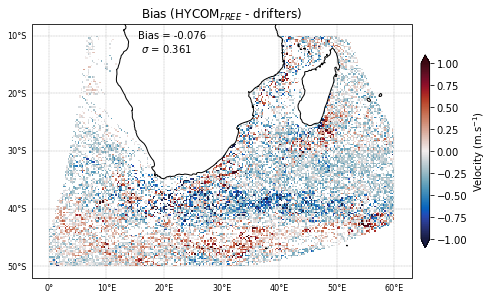

In [46]:
plotBias(free_drifters, 'FREE')

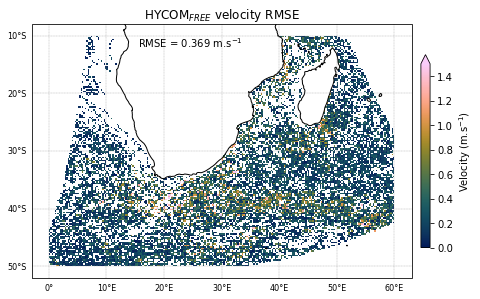

In [47]:
plotRMSE(free_drifters, 'FREE')

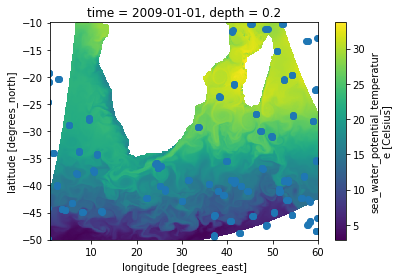

In [101]:
fig, ax = plt.subplots(1,1)

img = model['temperature'][0,0,:,:].plot(ax=ax)
ax.scatter(drifters_sub['longitude'], drifters_sub['latitude'])